## Imports and configs

In [1]:
import os
import warnings
from typing_extensions import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate
from langchain_mongodb.agent_toolkit import MongoDBDatabase
from langchain_mongodb.agent_toolkit.tool import QueryMongoDBCheckerTool, QueryMongoDBDatabaseTool
from langgraph.graph.message import add_messages
from pymongo import MongoClient


warnings.filterwarnings("ignore", category=UserWarning)

load_dotenv()


True

In [2]:
# define constants

class State(TypedDict , total=False ):  # <--- add total=False This tells Python and Pydantic that not all fields are required, so you can pass partial state dictionaries without validation errors.
    def __init__(self):
        self.messages = []
        self.query_retry = 0

    messages: Annotated[list, add_messages]
    question: str
    query: str
    result: str
    answer: str  
    output : str
    chart_type : str
    from_query : bool
    query_valid: bool
    query_retry: int


class QueryOutput(TypedDict):
    """Generated DB query."""

    query: Annotated[str, ..., "Syntactically valid database query."]


llm = AzureChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("OPENAI_ENDPOINT"),
    model="gpt-4o",
    temperature=0
    # timeout=None
)


config_memory = {"configurable": {"thread_id": "1"}}


MONGO_URI = os.getenv("MONGO_URI")
MONGO_DB_NAME = "sales"


# prompt templates
test_query = "generate only query to find the user ids of top 10 users with highest total purchase amount (quantity * price) from 'orders' collection?"

user_prompt = "Question: {input}"

mongodb_query_generator_prompt = """You are an agent designed to interact with a MongoDB database.
Given an input question, create a syntactically correct MongoDB query and return the query.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant field to return the most interesting examples in the database.
Never query for all the fields from a specific collection, only ask for the relevant fields given the question.

The query MUST be of the form: `db.collectionName.aggregate(...)`

Refer the database context below to construct your query.
{db_context}
"""

agent_system_prompt = """Answer the following questions as best you can. You have access to the following tools:
{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Thought:{agent_scratchpad}"""

classification_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that classifies user input into one of these categories: 'database', 'chart' or 'other'. Respond ONLY with one of these words. Do not explain."),
    ("human", "User: Count the number of customers from table Customer"),
    ("ai", "database"),
    ("human", "User: create a chart or grapgh"),
    ("ai", "chart"),        
    ("human", "User: Tell me a joke"),
    ("ai", "other"),
    ("human", "User: {input}")
])

In [3]:

def detect_intent(user_input: str) -> str:
    try:
        prompt = classification_prompt.invoke({"input": user_input},config=config_memory)
        result = llm.invoke(prompt ,config=config_memory)
        print(f"result ** {result}")
        intent = result.content.strip().lower()
        print(f" ********* detect_intent  intent value is **{intent}**   ")
        if intent not in ["database", "chart"]:
            return "other"
        return intent
    except Exception as e:
        print("❌ Intent detection failed:", e)
        return "other"


def create_sql_database_agent():
    pass


def create_mongodb_agent():
    client = MongoClient(MONGO_URI)
    db = MongoDBDatabase(client=client, database=MONGO_DB_NAME)
    return db

In [4]:
def write_mongodb_query(state: State) -> dict:
    """Generate SQL query to fetch information."""
    print(f" Generating query for: {state.get('question')}" )
    try:
        db = create_mongodb_agent()
        question = state.get("question")
        if not question:
            messages = state.get("messages", [])
            if messages and isinstance(messages[-1], HumanMessage):
                question = messages[-1].content

        query_prompt_template = ChatPromptTemplate([
            ("system", mongodb_query_generator_prompt),
            ("user", user_prompt)
        ])

        prompt = query_prompt_template.invoke(
            {
                "top_k": 5,
                "db_context": db.get_context(),
                "input": question,   ##state["question"]
            },
            config=config_memory
        )
        structured_llm = llm.with_structured_output(QueryOutput)
        result = structured_llm.invoke(prompt, config=config_memory)
        print("Generated Query:", result["query"])
        return {"query": result["query"]}
    except Exception as e:
        print("Query Generation failure:\n", e)
        return {"query": ""}
    

def check_mongodb_query(state: State) -> dict:
    """Check MongoDB query for correctness."""
    print(" Checking query: ", state.get("query"))
    db = create_mongodb_agent()
    execute_query_tool = QueryMongoDBCheckerTool(
        db=db,
        llm=llm,
        description='\n    Check if the query is correct.\n    If the query is not correct, an error message will be returned.\n    If an error is returned, rewrite the query, check the query, and try again.\n    '
    )
    result = execute_query_tool.invoke(state["query"], config=config_memory)
    # flag to indicate if the query is valid
    is_valid = False
    if result.content[1:7] == "python" or result.content[3:9] == "python" or result.content[1:5] == "json" or result.content[3:7] == "json":
        is_valid = True
    
    return {"result": result, "query_valid": is_valid}


def execute_mongodb_query(state: State) -> dict:
    """Execute MongoDB query."""
    print(" Executing query: ", state.get("query"))
    db = create_mongodb_agent()
    execute_query_tool = QueryMongoDBDatabaseTool(
        db=db,
        description = '\n    Execute a MongoDB query against the database and get back the result..\n    If the query is not correct, an error message will be returned.\n    If an error is returned, rewrite the query, check the query, and try again.\n    '
    )
    return {"result": execute_query_tool.invoke(state["query"],config=config_memory)}

In [5]:

def route(state: State) -> dict:

    print("** DEBUG  route(state: State) : ** ", state)

    messages = state.get("messages", [])
    if not any(isinstance(m, AIMessage) for m in messages):
        messages = [AIMessage(content="")] + messages
    if messages and isinstance(messages[-1], HumanMessage):
        user_input = messages[-1].content.strip().lower()
    else:
        user_input = "default"

    intent = detect_intent(user_input).strip().lower()        
    print(f"[Router] input = {user_input}")
    
    if any(k in user_input for k in ["table", "database", "query", "sql", "data", "record", "column"]):     ###intent == "database":
        print("📊 Route: table_node")
        return {"next": "table_node", "messages": messages, "question": user_input}
    # elif "chart" in intent:
    #     print("📊 Route: chart_node")
    #     return {"next": "chart_node", "messages": user_input}
    else:
        print("❓ Route: default")
        return {"next": "default", "messages": messages}


def default_response(state: State) -> State:
    # return {"messages": [model.invoke(state["messages"])]}
    return {"messages": [llm.invoke(state["messages"],config=config_memory)] }


def table_tool_node(state: State) -> State:
    print("🚨 Entered table_tool_node")

    # Step 1: Write MongoDB query
    result = write_mongodb_query(state)
    state.update(result)
    print("✅ write_query output:", result)

    # Step 2: Check MongoDB query
    result1 = check_mongodb_query(state)
    state.update(result1)
    print("✅ check_mongodb_query output:", result1)

    if not state.get("query_valid", True):
        print("❌ Query invalid, retrying...")
        retries = state.get("query_retry", 0)
        retries += 1
        state.update({"query_retry": retries})
        if retries > 3:
            print("❌ Too many retries, returning error message.")
            state["messages"].append(AIMessage(content="❌ Query is invalid after multiple attempts. Please try again with a different question."))
            return state
        return table_tool_node(state)

    # Step 3: Execute MongoDB query
    result2 = execute_mongodb_query(state)
    state.update(result2)
    print("✅ execute_mongodb_query output:", result2)

    # Add to messages for UI
    
    # chart_type = get_chart_type(state.get('question'))
    # if chart_type:  
    #     # state["messages"].append(AIMessage(content=f"Chart type detected: {chart_type}"))
    #     state["chart_type"] = chart_type
    #     print(f"🚨 chart_type detected: {chart_type}")  
    state["from_query"] = True
    #     create_chart(state) 
    # else:
    # Step 4: Generate final answer
    # result3 = generate_answer(state)
    # state.update(result3)
    # print("✅ generate_answer output:", result3)        

    state["messages"] = state.get("messages", []) + [AIMessage(content=state.get("answer", "No answer"))]
    return state

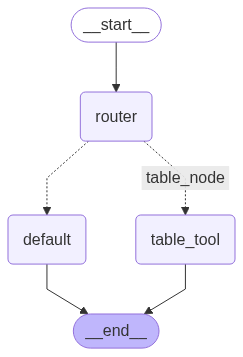

In [6]:
from langgraph.graph import StateGraph, START, END


graph = StateGraph(State)

graph.add_node("router", route)
graph.add_node("table_tool", table_tool_node)
graph.add_node("default", default_response)

graph.set_entry_point("router")

graph.add_conditional_edges(
    "router",
    # 👇 key to look inside router's return value
    lambda state: state["next"],
    path_map={
        "table_node": "table_tool",
        "default": "default"
    }
)

graph.add_edge("table_tool", END)
graph.add_edge("default", END)

app = graph.compile()

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
result = app.invoke({
    "messages": [HumanMessage(content=test_query)]
})
print(result)

** DEBUG  route(state: State) : **  {'messages': [HumanMessage(content="generate only query to find the user ids of top 10 users with highest total purchase amount (quantity * price) from 'orders' collection?", additional_kwargs={}, response_metadata={}, id='3676df5c-4fa2-49e9-a851-85b4d31306ee')]}
result ** content='database' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 131, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C0gyOC2xOBnwn3mOlv7c9YXCr7FpX', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_ha

In [8]:
pipeline = [
    {"$project": {"user_id": 1, "total_purchase": {"$multiply": ["$quantity", "$price"]}}},
    {"$group": {"_id": "$user_id", "total_purchase_amount": {"$sum": "$total_purchase"}}},
    {"$sort": {"total_purchase_amount": -1}},
    {"$limit": 5}
]

client = MongoClient(MONGO_URI)
db = client[MONGO_DB_NAME]

result = list(db['orders'].aggregate(pipeline))
# print(result)

# print(db.orders.aggregate(
#     [{"$group": {"_id": "$user_id", "total_purchase_amount": {"$sum": {"$multiply": ["$quantity", "$price"]}}}}, {"$sort": {"total_purchase_amount": -1}}, {"$limit": 10}, {"$project": {"user_id": "$_id", "_id": 0}}]
# ))

{'result': AIMessage(content="Please provide the MongoDB query you'd like me to review.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 96, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C07GVkvU6no9qZnFL8z0sGPETqw85', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run--f973a3cd-66de-4e10-94f7-1e2afce2aaaf-0', usage_metadata={'input_tokens': 96, 'output_tokens': 13, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'query_valid': True}

{'result': AIMessage(content='```javascript\ndb.orders.aggregate([\n  {\n    $group: {\n      _id: "$user_id",\n      total_purchase_amount: {\n        $sum: {\n          $multiply: ["$quantity", "$price"]\n        }\n      }\n    }\n  },\n  {\n    $sort: {\n      total_purchase_amount: -1\n    }\n  },\n  {\n    $limit: 10\n  },\n  {\n    $project: {\n      user_id: "$_id",\n      _id: 0\n    }\n  }\n])\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 202, 'total_tokens': 313, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C07H7FNwfiZZykN8IfaUcYFHWzXri', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run--284f6b43-10bc-4570-9604-7fd906ac29fc-0', usage_metadata={'input_tokens': 202, 'output_tokens': 111, 'total_tokens': 313, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'query_valid': True}